

---


![alt text](https://imgcdn.sdk.cn/company/XOaU06okUMO47fGEjlxD.png?imageMogr2/thumbnail/180x) 




---

# Predicting Similarity in Quora Question Pairs



---



## The Deep Learning Approach Using Siamese Manhattan LSTMs - Mueller & Thyagarajan (2016)


---



##  Libraries and Modules


**Importing the required libraries and modules. Keras has an implementation of the MaLSTM that is used here. The choice of optimizer is the AdaDelta optimizer which is commonly used in Natural Language Understanding use cases(Bowman et al 2015, Peng et al 2015, Dong et al 2015). 
**


In [0]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
Using TensorFlow backend.


## Preprocessing the text data


**Using the NLTK library to remove stop words from the data set. Using regular expressions to eliminate contractions such as _I'm_, _what's_, etc., format abbreviations, and to clean up the trailing white spaces after removing punctuations, stops and special characters.**


In [0]:
import nltk
nltk.download("popular")

stops = set(nltk.corpus.stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.split()

    return text

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

## Setting up a completely cloud-based environment for Deep Learning with Google Colab

**We can mount Drive files on a Colab project online and move the entire project to the cloud including the input and output data. PyDrive is a Python wrapper and the google.colab method can both be used to do this.**


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive"

 ANN_final
 ANN_Final.gslides
 Classroom
'Colab Notebooks'
 Comrie6_Notes.gdoc
 Corpora
 Dissertation.gdoc
'Explara _ Registrations.pdf'
 homework_dipika.txt
 LS386_Final_Dipika.gslides
 NaturalLanguageArithmeticStatementsinTelugu.gdoc
 NDWNXUW.pdf
 Psycholinguistics_Spring2019
 Resume_Parser_adhoc_Dipika.gdoc
 resume_short.pdf
 RocketBook_Notes
 Skill_Development.gsheet
 Statement_of_Purpose.gdoc
 Syllabus.gsheet
 TextGenLSTM.gslides
'Untitled presentation.gslides'


### Loading the Quora Question Pair data set from Drive.

In [0]:

train_df = pd.read_csv('/content/drive/My Drive/ANN_final/quora-question-pairs/train.csv')


In [0]:
test_df = pd.read_csv('/content/drive/My Drive/ANN_final/quora-question-pairs/test.csv')

### Installing and authorizing the PyDrive package.

In [0]:
!pip install -U -q PyDrive

    100% |████████████████████████████████| 993kB 19.2MB/s 


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


### Loading the pretrained Google Word2Vec Model from an AWS cloud container.

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-04-23 19:30:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.245
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  49.5MB/s    in 28s     

2019-04-23 19:30:36 (57.1 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



## Word2Vec

**The Quora Question Pairs data set is quite large. The train set contains 2.35 million questions and the test set contains 400,000 questions. In order to make a robust and generalizable model on such big data we are using the pretrained model from Google which contains 1.5 gigabytes of pretrained vector representations.**

In [0]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

### The word2vec variable contains the Google word embeddings.

In [0]:
# test

word2vec['dog'].shape

(300,)

### The vocabulary variable is a dictionary where the keys are strings and the values are the corresponding indices (a unique id which is an int).


In [0]:
vocabulary = dict()
inverse_vocabulary = ['<unk>']

### The question_cols variable is a dataframe which has both the question columns.

In [0]:
questions_cols = ['question1', 'question2']


### In the following code block, we are iterating over the questions in each column and appending them to the inverse_vocanulary variable if they are unfamiliar words.

In [0]:
# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Creating the Embedding Matrix

### The below code matches each word in the question_cols variable to its corresponding word embedding from the word2vec model and assigns the first index of each embedding to zero. The words that are recognized as _unks_ are assigned a random embedding, however, it will not affect the accuracy of our model because the _unks_ are less than 0.5% of the dataset.

In [0]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

In [0]:
# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

## MaLSTM Data Preprocessing :

**Due to the architecure of the MaLSTM, we need to split the train and test data sets differently than we do in regular ML and DL models. We split the input into left and right components and we pad the sequences with zeroes.**


**We are creating a validation set that contains 40,000 instances.**

In [0]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

In [0]:
# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)


In [0]:
# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)


## Model Parameters

**The Siamese Recurrent Architecture works like two LSTMs that are mirroring each other and we need to merge them at sometime. Keras has built-in methods such as the _Merge_ layer that will help us merge the two MaLSTMs that we trained in order to see if there are duplicates in each pair and if so, to what extent.**

**We are training for 10 epochs with a batch-size of 128. Kaggle users who have access to powerful local GPUs such as the GTX 1060 and up, have trained this model for 25 epochs or more without much improvement in accuracy after 10 epochs. The model peaks at 7-8 epochs unlike other DL models which perform better upon training for several tens of epochs.**

In [0]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 10

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))



In [0]:
# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


## Training :

**The model was trained for 10 epochs which took rouchly 9 hours on the K80 cloud GPU with hosted runtime on Google Colab. The loss function steadily minimised in the first few epochs and the accuracy shot as you can see below, however, after epoch 7/10 the rate of change of cost function as well as accuracy reduced significantly.**

In [0]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 364290 samples, validate on 40000 samples
Epoch 1/10
364290/364290 [==============================] - 3265s 9ms/step - loss: 0.1723 - acc: 0.7503 - val_loss: 0.1670 - val_acc: 0.7659
Epoch 2/10
364290/364290 [==============================] - 3273s 9ms/step - loss: 0.1587 - acc: 0.7754 - val_loss: 0.1579 - val_acc: 0.7795
Epoch 3/10
364290/364290 [==============================] - 3275s 9ms/step - loss: 0.1517 - acc: 0.7874 - val_loss: 0.1508 - val_acc: 0.7843
Epoch 4/10
364290/364290 [==============================] - 3260s 9ms/step - loss: 0.1471 - acc: 0.7953 - val_loss: 0.1508 - val_acc: 0.7942
Epoch 5/10
364290/364290 [==============================] - 3267s 9ms/step - loss: 0.1438 - acc: 0.8002 - val_loss: 0.1512 - val_acc: 0.7792
Epoch 6/10
364290/364290 [==============================] - 3252s 9ms/step - loss: 0.1414 - acc: 0.8045 - val_loss: 0.1440 - val_acc: 0.8006
Epoch 7/10
364290/364290 [==============================] - 3261s 9ms/step - loss: 0.1394 - acc: 0.8070

## Plotting the results :

**Below are the plots for the accuracy and loss function progress through the training process.**

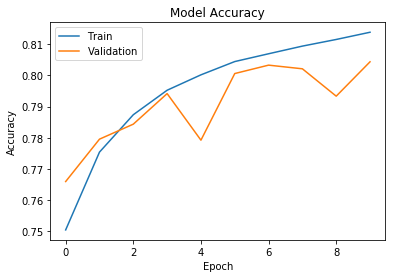

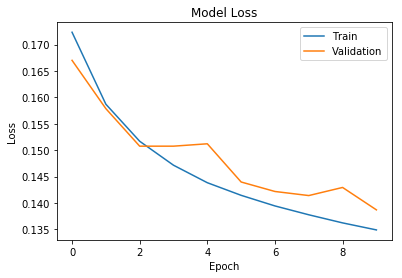

In [0]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Saving and reusing :

**We can save the model directly to Goodle Drive in JSON and H5 formats so we can reload the training weights and deploy the model if we wish to.**

In [0]:
# serialize model to JSON
model_json = malstm_trained.model.to_json()
with open("/content/drive/My Drive/ANN_final/QQP_model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
# serialize weights to HDF5
malstm_trained.model.save_weights("/content/drive/My Drive/ANN_final/QQP_model.h5")
print("Saved model to disk")

Saved model to disk
